Справочная информация: https://trudvsem.ru/opendata/api

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json

import warnings
warnings.filterwarnings('ignore')

# Задание 1

Попробуем забирать данные из открытого API opendata.trudvsem.ru

Напиши функцию, которая принимает на вход ключевое слово или фразу и выдает количество вакансий в базе на текущий момент (параметр total в ответе от сервера). Необходимо использовать поиск по тексту, подробнее в документации https://trudvsem.ru/opendata/api

In [ ]:
def get_vacancies(job_tag):

    #код решения
    req = requests.get("https://opendata.trudvsem.ru/api/v1/vacancies?text="+job_tag)
    result = req.json()['meta']['total']

    print(f"По тегу '{job_tag}' на текущий момент открыто {result} вакансий")

In [ ]:
get_vacancies('врач')

По тегу 'врач' на текущий момент открыто 48178 вакансий


# Задание 2

Сформируем для работу свою базу, ищем вакансии на аналитиков.

Выгрузи из базы все вакансии, в описании или названии которых есть ключевое слово "аналитик". Так как ресурс ограничивает выдачу на 100 вакансий, а всего в базе их может быть несколько тысяч, необходимо запустить вызов requests.get() в цикле и забрать данные с каждой страницы. Как это сделать описано в документации к API в разделе "Пагинация". Ответ из первого задания поможет оценить, сколько раз нужно будет запускать цикл.

В результате выполнения метода requests.get() на выходе мы получим json, который необходимо будет преобразовать в датафрейм, используя pd.json_normalize().

Оставь в датафрейме только те вакансии, у которых содержится "аналитик" в столбце job-name. Для самопроверки: за 2022 год таких вакансий должно получиться 150-200+. Из-за обновления базы и удаления закрытых вакансий мы не можем зафиксировать точное количество на момент выполнения данного задания.

In [ ]:
# место для решения
req = requests.get('http://opendata.trudvsem.ru/api/v1/vacancies?text=аналитик')
req_dict=json.loads(req.text)
import math
cnt_offset=math.ceil(req_dict['meta']['total']/100)
cnt_offset
result_all_offset=[]

# Для постраничной загрузки результатов в URL используем параметр oﬀset=i, который итерируется в цикле
for i in range(cnt_offset):
  text_req='http://opendata.trudvsem.ru/api/v1/vacancies?text=аналитик&offset=' + str(i)+ '&limit=100'
  req = requests.get(text_req)
  req_dict=json.loads(req.text)
  result=req_dict['results']['vacancies'] # type(result)=lis
  result_all_offset.extend(result)
  #print(len(result_all_offset))

# Количество вакансий в финальном датасете больше 100
print(f"Количество вакансий по тегу аналитик составляет {len(result_all_offset)} штук")

# Для парсинга json ответа используем метод pd.json_normalize()
df2 = pd.DataFrame.from_dict(pd.json_normalize(result_all_offset), orient='columns')
print(f"Первоначальный датасет после парсинка json размером {df2.shape}")
df2.head(2)

# Вакансии отфильтрованы по наличию слова "аналитик" в стоблце job-name
data_filter = (df2['vacancy.job-name'].str.lower().str.contains('аналитик'))
df2=df2.loc[data_filter]

print(f"Датасет после фильтрации по стоблце job-name=аналитик размером {df2.shape}")

# Выделяем колонку с годом создания вакансии
df2['year-creation1']=pd.to_datetime(df2['vacancy.creation-date'])
df2['year-creation2']=df2['year-creation1'].dt.year

# Для самопроверки: за 2022 год таких вакансий должно получиться 150-200+.
# Из-за обновления базы и удаления закрытых вакансий мы не можем зафиксировать точное количество на момент выполнения данного задания.
data_filter = (df2['vacancy.job-name'].str.lower().str.contains('аналитик')) & df2['year-creation2'].between(2022, 2022)
print(f"Датасет по аналитикам за 2022 год размером {df2.loc[data_filter].shape}")

Количество вакансий по тегу аналитик составляет 2243 штук
Первоначальный датасет после парсинка json размером (2243, 36)
Датасет после фильтрации по стоблце job-name=аналитик размером (975, 36)
Датасет по аналитикам за 2022 год размером (168, 38)


# Задание 3

Оценим количество открытых вакансий на текущую дату.
Используя датафрейм, полученный в предыдущем задании, построй график с количеством вакансий по годам (linechart или barplot). Обязательно укажи названия осей и заголовок.


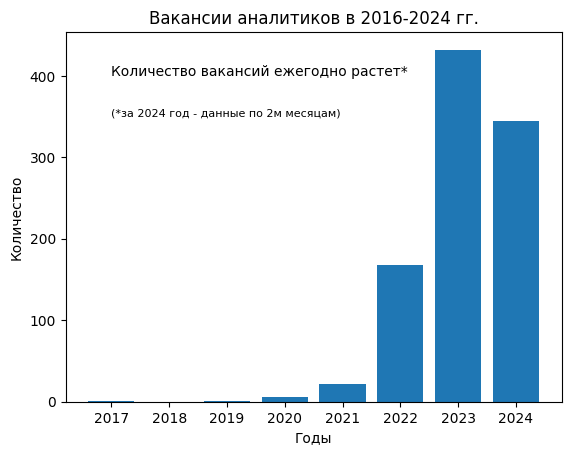

In [ ]:
# место для решения
df_graf1=df2[['vacancy.job-name','year-creation2']]
df_graf1_grp=df_graf1.groupby(by='year-creation2').count()
df_graf1_grp=df_graf1_grp.reset_index()

import seaborn as sns
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,8))
plt.title("Вакансии аналитиков в 2016-2024 гг.")
plt.xlabel("Годы")
plt.ylabel("Количество")
plt.text(2017, 400, 'Количество вакансий ежегодно растет*')
plt.text(2017, 350, '(*за 2024 год - данные по 2м месяцам)', size=8)
plt.bar(df_graf1_grp['year-creation2'], df_graf1_grp['vacancy.job-name'])
plt.show()

# Задание 4

Посмотрим, в каких отраслях в последние годы требуются специалисты с навыками аналитика.
1. Выбери из датафрейма вакансии, которые были опубликованы в 2021 и 2022 годах (столбец creation-date).
2. Выведи общее количество вакансий за эти два года.
3. Построй круговую диаграмму с распределением вакансий по отраслям (specialisation). Убери название оси (ylabel = '') и укажи заголовок.
4. Чтобы диаграмма не забивалась отраслями, в которых мало вакансий, сделай категорию "Другое", в которую уйдут отрасли с количеством вакансий 5 и меньше.
5. Подпиши на самом графике, сколько вакансий в каждой из отраслей.

Датасет после фильтрации 2021-2022гг. размером (190,)
 
                                      specialisation  cnt
0  Информационные технологии, телекоммуникации, с...   56
1                                             Другое   37
2  Государственная служба, некоммерческие организ...   21
3                                       Производство   16
4           Здравоохранение и социальное обеспечение   15
5           Бухгалтерия, налоги, управленческий учет   13
6  Банки, кредит, страхование, пенсионное обеспеч...   12
7              Продажи, закупки, снабжение, торговля    8
8                                 Образование, наука    6
9  Строительство, ремонт, стройматериалы, недвижи...    6
 
Проверка сохранения общего количества вакансий после формированя категории Другое: 190


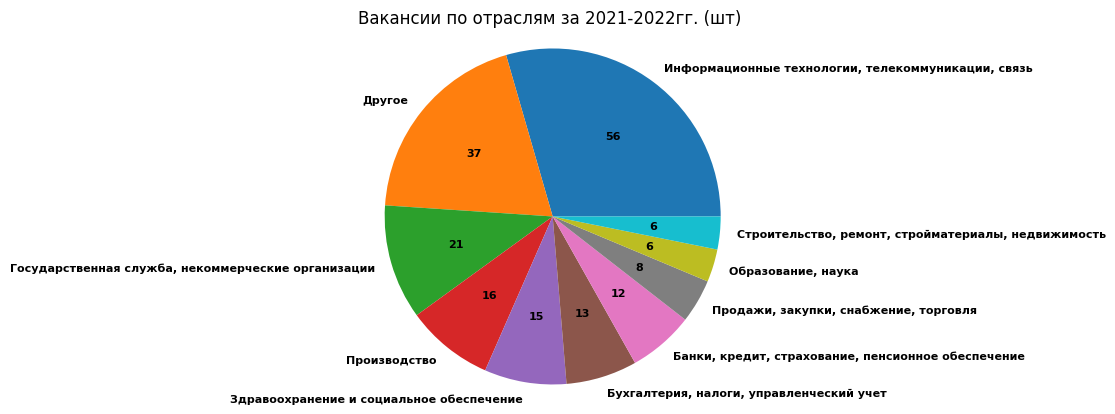

In [ ]:
# место для решения
df_graf2=df2[['vacancy.category.specialisation','year-creation2']]

# Отфильтруем датафрейм по году - только 2021 и 2022
data_filter = df_graf2['year-creation2'].between(2021, 2022)
df_graf2_2122=df_graf2.loc[data_filter]['vacancy.category.specialisation']
df_=df_graf2_2122.value_counts().reset_index()
df_.columns=['specialisation','cnt']
print(f"Датасет после фильтрации 2021-2022гг. размером {df_graf2_2122.shape}")

# Cделаем категорию "Другое", в которую уйдут отрасли с количеством вакансий 5 и меньше
data_filter = (df_['cnt']<6)
df_.loc[data_filter, ['specialisation']]='Другое'

df3=df_.groupby(by='specialisation').sum().reset_index().sort_values('cnt', ascending=False).reset_index().drop('index',axis=1)
print(' ')
print(df3)
print(' ')
print(f"Проверка сохранения общего количества вакансий после формированя категории Другое: {df3['cnt'].sum()}")

# Выведем круговую диаграмму по отраслям
fig1, ax1 = plt.subplots()
val=df3['cnt']
wedges, texts, autotexts = ax1.pie(df3['cnt'],
                                   labels=df3['specialisation'],
                                   autopct=lambda p:f'{p*sum(val)/100 :.0f}',
                                   textprops=dict(color='k', weight='bold', fontsize=8))
ax1.axis('equal')
plt.title('Вакансии по отраслям за 2021-2022гг. (шт) ')
plt.show()

# Задание 5

Оценим, как влияет опыт работы на ожидания по заработной плате.
1. Оставь в датафрейме только вакансии с полной занятостью (поле employment), чтобы избежать перекосов по зарплате за неполный рабочий день.
2. Разбей вакансии на категории по опыту работы ['0', '1-3', '4+']. В столбце с опытом работы есть ошибка, необходимо привести все значения к одному типу данных.
3. Рассчитай среднюю зарплату, используя значения минимальной и максимальной зарплаты. Если при заполнении вакансии оставили поле с максимальной зарплатой пустым, там будет 0. В таких строках необходимо использовать для salary_max такое же значение, как и salary_min.
4. Убери из выборки вакансии, в которых минимальная зарплата = 0, значит ее не заполнили при размещении вакансии.
5. Построй диаграмму boxplot, на которой будут отоюражаться распределения средней заработной платы по разным категориям опыта.
6. Изучи вакансии из категории 4+ и запиши 3 гипотезы, почему зарплаты в объявлении не возросли относительно категории 1-3.

Датасет после фильтрации по стоблце job-name=аналитик размером (975, 38)
Количество вакансий с Полной занатостью (948, 9)
Количество вакансий с за период 2021-2022гг. (187, 9)
Количество вакансий с зарлатой большй нуля (166, 10)


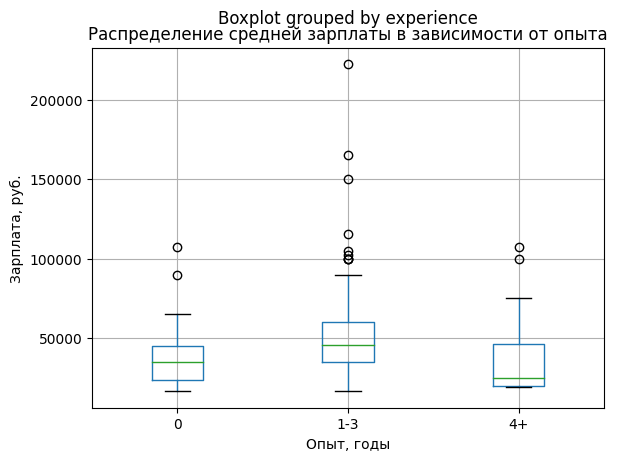

In [ ]:
# место для решения
print(f"Датасет после фильтрации по стоблце job-name=аналитик размером {df2.shape}")
df_graf3=df2[['vacancy.employment',
              'vacancy.salary',
              'vacancy.salary_min',
              'vacancy.salary_max',
              'year-creation2',
              'vacancy.schedule', 'vacancy.requirement.experience', 'vacancy.duty',
              'vacancy.region.region_code']]

# Оставь в датафрейме только вакансии с полной занятостью (поле employment), чтобы избежать перекосов по зарплате за неполный рабочий день.
df_graf3_ful_emp=df_graf3[df_graf3['vacancy.employment']=='Полная занятость']
print(f"Количество вакансий с Полной занатостью {df_graf3_ful_emp.shape}")

#- датафрейм отфильтрован по году (либо уже отфильтрован ранее) и типу занятости
df_graf3_ful_emp=df_graf3_ful_emp[df_graf3_ful_emp['year-creation2'].between(2021,2022)]
print(f"Количество вакансий с за период 2021-2022гг. {df_graf3_ful_emp.shape}")

# В столбце с опытом работы есть ошибка, необходимо привести все значения к одному типу данных.
data_filter=df_graf3_ful_emp['vacancy.requirement.experience']=='от 0'

# заменяем в отфильтрованных записях значение 'от 0' на 0
df_graf3_ful_emp.loc[data_filter,['vacancy.requirement.experience']]=0

# Разбей вакансии на категории по опыту работы ['0', '1-3', '4+'].
d_filter1=df_graf3_ful_emp['vacancy.requirement.experience'].between(0, 0)
d_filter2=df_graf3_ful_emp['vacancy.requirement.experience'].between(1, 3)
d_filter3=df_graf3_ful_emp['vacancy.requirement.experience'].between(4, 1000)

# Столбец с опытом разбит на категории ['0', '1-3', '4+']
df_graf3_ful_emp['experience']='0'
df_graf3_ful_emp.loc[d_filter1,['experience']]='0'
df_graf3_ful_emp.loc[d_filter2,['experience']]='1-3'
df_graf3_ful_emp.loc[d_filter3,['experience']]='4+'

# Уберем из выборки вакансии, в которых минимальная зарплата = 0, значит ее не заполнили при размещении вакансии.
df_graf3_ful_emp = df_graf3_ful_emp[df_graf3_ful_emp['vacancy.salary_min'] != 0]
print(f"Количество вакансий с зарлатой большй нуля {df_graf3_ful_emp.shape}")

# Рассчитай среднюю зарплату, используя значения минимальной и максимальной зарплаты.
# Если при заполнении вакансии оставили поле с максимальной зарплатой пустым, там будет 0.
# В таких строках необходимо использовать для salary_max такое же значение, как и salary_min.

# - в столбце salary_max строки с 0 заменены на значения из столбца salary_min,
df_graf3_ful_emp2=df_graf3_ful_emp.copy()
df_graf3_ful_emp2.loc[df_graf3_ful_emp2['vacancy.salary_max'] == 0, ['vacancy.salary_max']] =df_graf3_ful_emp2['vacancy.salary_min']


# Рассчет средней зарплаты, используя значения минимальной и максимальной зарплаты (max + min) / 2
df_graf3_ful_emp2['salary_mean']=(df_graf3_ful_emp2['vacancy.salary_max']+df_graf3_ful_emp2['vacancy.salary_min'])/2

# Построй диаграмму boxplot, на которой будут отоюражаться распределения средней заработной платы по разным категориям опыта.
# - отображена диаграмма "ящик с усами", на которой в идны среднюю зарплату и разброс по вакансиям в зависимости от опыта работы
df4=df_graf3_ful_emp2[['salary_mean','experience','vacancy.duty', 'vacancy.region.region_code']]
df4.boxplot(column=['salary_mean'], by='experience')
plt.xlabel('Опыт, годы')
plt.ylabel('Зарплата, руб.')
plt.title('Распределение средней зарплаты в зависимости от опыта')
plt.show()

In [ ]:
# Изучи вакансии из категории 4+ и запиши 3 гипотезы, почему зарплаты в объявлении не возросли относительно категории 1-3.
# Гипотеза
df4['FO']=df4['vacancy.region.region_code']
dic = {
'0100000000000' : 'ЮФО',
'0200000000000' : 'ПФО',
'0300000000000' : 'СФО',
'0400000000000' : 'СФО',
'0500000000000' : 'СКФО',
'0600000000000' : 'СКФО',
'0700000000000' : 'СКФО',
'0800000000000' : 'ЮФО',
'0900000000000' : 'СКФО',
'1000000000000' : 'СЗФО',
'1100000000000' : 'СЗФО',
'1200000000000' : 'ПФО',
'1300000000000' : 'ПФО',
'1400000000000' : 'ДФО',
'1500000000000' : 'СКФО',
'1600000000000' : 'ПФО',
'1700000000000' : 'СФО',
'1800000000000' : 'ПФО',
'1900000000000' : 'СФО',
'2000000000000' : 'СКФО',
'2100000000000' : 'ПФО',
'2200000000000' : 'СФО',
'2300000000000' : 'ЮФО',
'2400000000000' : 'СФО',
'2500000000000' : 'ДФО',
'2600000000000' : 'СКФО',
'2700000000000' : 'ДФО',
'2800000000000' : 'ДФО',
'2900000000000' : 'СЗФО',
'3000000000000' : 'ЮФО',
'3100000000000' : 'ЦФО',
'3200000000000' : 'ЦФО',
'3300000000000' : 'ЦФО',
'3400000000000' : 'ЮФО',
'3500000000000' : 'СЗФО',
'3600000000000' : 'ЦФО',
'3700000000000' : 'ЦФО',
'3800000000000' : 'СФО',
'3900000000000' : 'СЗФО',
'4000000000000' : 'ЦФО',
'4100000000000' : 'ДФО',
'4200000000000' : 'СФО',
'4300000000000' : 'ПФО',
'4400000000000' : 'ЦФО',
'4500000000000' : 'УФО',
'4600000000000' : 'ЦФО',
'4700000000000' : 'СЗФО',
'4800000000000' : 'ЦФО',
'4900000000000' : 'ДФО',
'5000000000000' : 'ЦФО',
'5100000000000' : 'СЗФО',
'5200000000000' : 'ПФО',
'5300000000000' : 'СЗФО',
'5400000000000' : 'СФО',
'5500000000000' : 'СФО',
'5600000000000' : 'ПФО',
'5700000000000' : 'ЦФО',
'5800000000000' : 'ПФО',
'5900000000000' : 'ПФО',
'6000000000000' : 'СЗФО',
'6100000000000' : 'ЮФО',
'6200000000000' : 'ЦФО',
'6300000000000' : 'ПФО',
'6400000000000' : 'ПФО',
'6500000000000' : 'ДФО',
'6600000000000' : 'УФО',
'6700000000000' : 'ЦФО',
'6800000000000' : 'ЦФО',
'6900000000000' : 'ЦФО',
'7000000000000' : 'СФО',
'7100000000000' : 'ЦФО',
'7200000000000' : 'УФО',
'7300000000000' : 'ПФО',
'7400000000000' : 'УФО',
'7500000000000' : 'СФО',
'7600000000000' : 'ЦФО',
'7700000000000' : 'г. Москва',
'7800000000000' : 'г.С-Петербург',
'7900000000000' : 'ДФО',
'8300000000000' : 'СЗФО',
'8600000000000' : 'УФО',
'8700000000000' : 'ДФО',
'8900000000000' : 'УФО',
'9100000000000' : 'КФО',
'9200000000000' : 'КФО'
}

df4['FO'] = df4['FO'].map(dic)
df4['cnt']=1
pd.pivot_table(df4,
                index='FO',
                columns='experience',
                values='cnt',
                aggfunc=np.sum)



experience,0,1-3,4+
FO,,,
ДФО,7.0,3.0,2.0
КФО,1.0,2.0,NaN
ПФО,7.0,19.0,8.0
СЗФО,2.0,6.0,1.0
СФО,4.0,2.0,2.0
УФО,8.0,14.0,1.0
ЦФО,11.0,20.0,5.0
ЮФО,4.0,8.0,2.0
г. Москва,1.0,10.0,2.0


In [ ]:
# Выводы:
# Большее количество вакансий "1-3" сосредоточено в г.Москва, г.Санкт-Петербург, и ближнем Подмосковье  (ЦФО, ПФО). В этих регоинах зарплата выше, чем в среднем по России.

# Более интерсный вопрос - почему в этих регионах спрос на более опытных кандиатов "4+"" ниже, чем с опытом в "1-3" года.
# В регионах совсем немного стартапов, возможно анлитики требуются в госструкурах где преобладает огранеиченное бюджетное финансирование, при этом ответственность довольно высокая.

# Среди работодателей из Центра возможно преобладают новые стартапы,  делающие ставку на ускоренный рост, в ссвязи с чем и требуются аналитики.
# Для молодыхъ команд требуются "заряженные", не выгоревшие работники.

# Зарплата на сайте - это еще не факт, что будет выплачена, работодатели могут заманивать большой зарплатой середнячков "1-3", а платить по факту меньше.
# Приглашая более опытных кандидатов "4+" на серьезные проекты играть с зарплатами нецелесообразно.


# Дополнительное задание

Изучим основные сущности, которые встречаются в описании к вакансиям: что надо делать (глаголы) и с чем работать (существительные). Построим облака слов (как в проекте 12), но предварительно подготовим текстовые данные с помощью библиотеки pymorphy2.

1. Установи библиотеку pymorphy2.
2. Приведи все описания в столбце duty к нижнему регистру
3. Создай пустую сроку и собери в нее в один текст все описания из столбца duty
4. Очисти текст от служебных символов и разметки (<, /, &nbsp, \n и др.)
5. Используя pymorphy2.MorphAnalyzer(lang='ru') приведи каждое слово в тексте к нормальной форме.
6. Раздели все слова по частям речи: в один список существительные, в другой список - глаголы. Не удаляй дубликаты - они будут влиять на размер слова в облаке. Часть речи можно определить по morph.parse(word)[0].tag.POS (см. документацию pymorphy2)
7. С помощью ранее установленной библиотеки wordcloud выведи 2 облака слов: существительные и глаголы.

In [ ]:
# место для решения
# Установи библиотеку pymorphy2.
!pip install pymorphy2

In [ ]:
import pymorphy2

# Приведи все описания в столбце duty к нижнему регистру
df5=df4['vacancy.duty'].str.lower()

# Описания всех вакансий из столбца duty объединяем в текст
df5_str = ','.join(df5.astype(str))

# Очищаем описания вакансий от служебных символов
import re
df5_lst_clear=re.findall(r'[а-яё]+', df5_str)

# Используя pymorphy2.MorphAnalyzer(lang='ru') приведи каждое слово в тексте к нормальной форме.
# Раздели все слова по частям речи: в один список существительные, в другой список - глаголы.
# Не удаляй дубликаты - они будут влиять на размер слова в облаке.
# Часть речи можно определить по morph.parse(word)[0].tag.POS (см. документацию pymorphy2)
morph= pymorphy2.MorphAnalyzer(lang='ru')
noun_lst = [morph.parse(word)[0].normal_form for word in df5_lst_clear if morph.parse(word)[0].tag.POS == 'NOUN']
verb_lst = [morph.parse(word)[0].normal_form for word in df5_lst_clear if morph.parse(word)[0].tag.POS == 'VERB' or morph.parse(word)[0].tag.POS == 'INFN']

print(f"Количество существительных = {len(noun_lst)}")
print(f"Количество глаголов = {len(verb_lst)}")

Количество существительных = 4635
Количество глаголов = 212


In [ ]:
# Чек-лист (одни из самых крупных: анализ, разработка, подготовка)
from collections  import Counter
categories_cnt = Counter(noun_lst)
categories_cnt.most_common(7)

[('анализ', 122),
 ('работа', 95),
 ('система', 89),
 ('разработка', 78),
 ('требование', 71),
 ('процесс', 67),
 ('подготовка', 64)]

In [ ]:
# Чек-лист (одни из самых крупных: (проводить, осуществлять, контролировать).
categories_cnt2 = Counter(verb_lst)
categories_cnt2.most_common(8)

[('осуществлять', 19),
 ('проводить', 18),
 ('формировать', 12),
 ('разрабатывать', 11),
 ('участвовать', 11),
 ('анализировать', 10),
 ('собирать', 7),
 ('подготавливать', 7)]

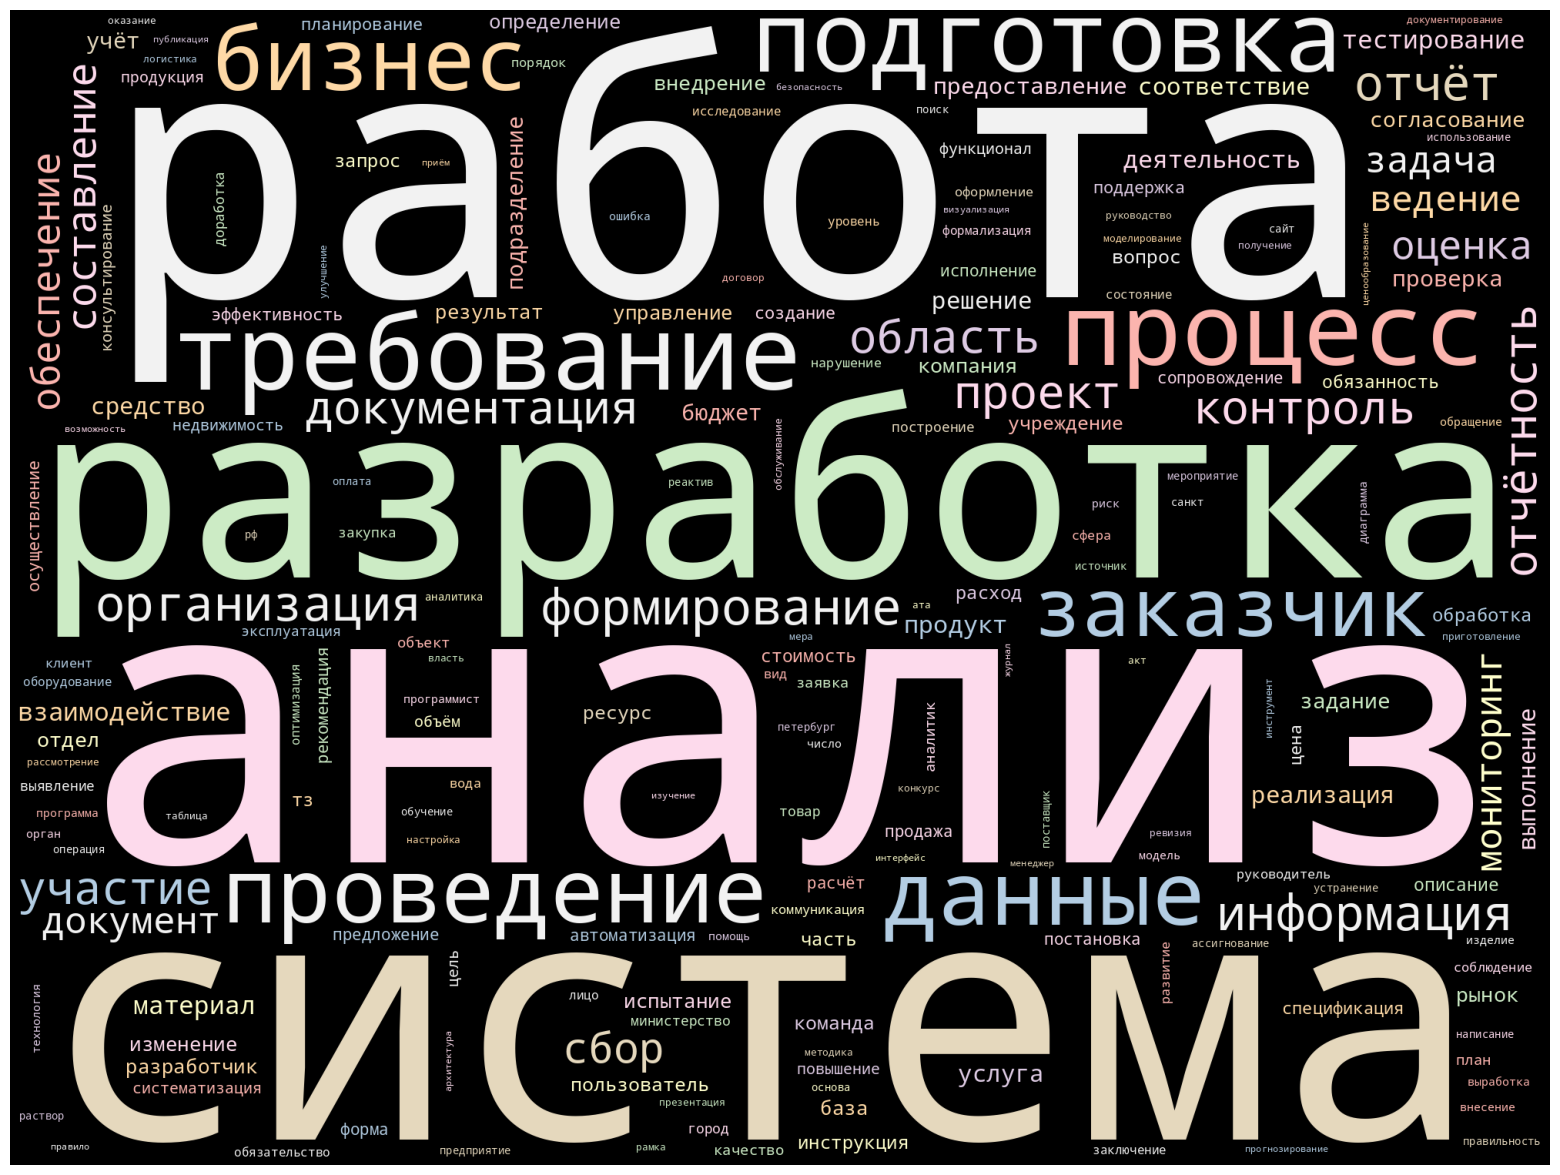

In [ ]:
# С помощью ранее установленной библиотеки wordcloud выведи 2 облака слов: существительные и глаголы.
from wordcloud import WordCloud

def plot_cloud(wordcloud):
    # Устанавливаем размер картинки
    plt.figure(figsize=(20, 15))
    # Показать изображение
    plt.imshow(wordcloud)
    # Без подписей на осях
    plt.axis("off")

wordcloud_noun = WordCloud(width = 2000,
                      height = 1500,
                      random_state=1,
                      background_color='black',
                      margin=20,
                      colormap='Pastel1',
                      collocations=False).generate(' '.join(noun_lst))

plot_cloud(wordcloud_noun) # Рисуем картинку

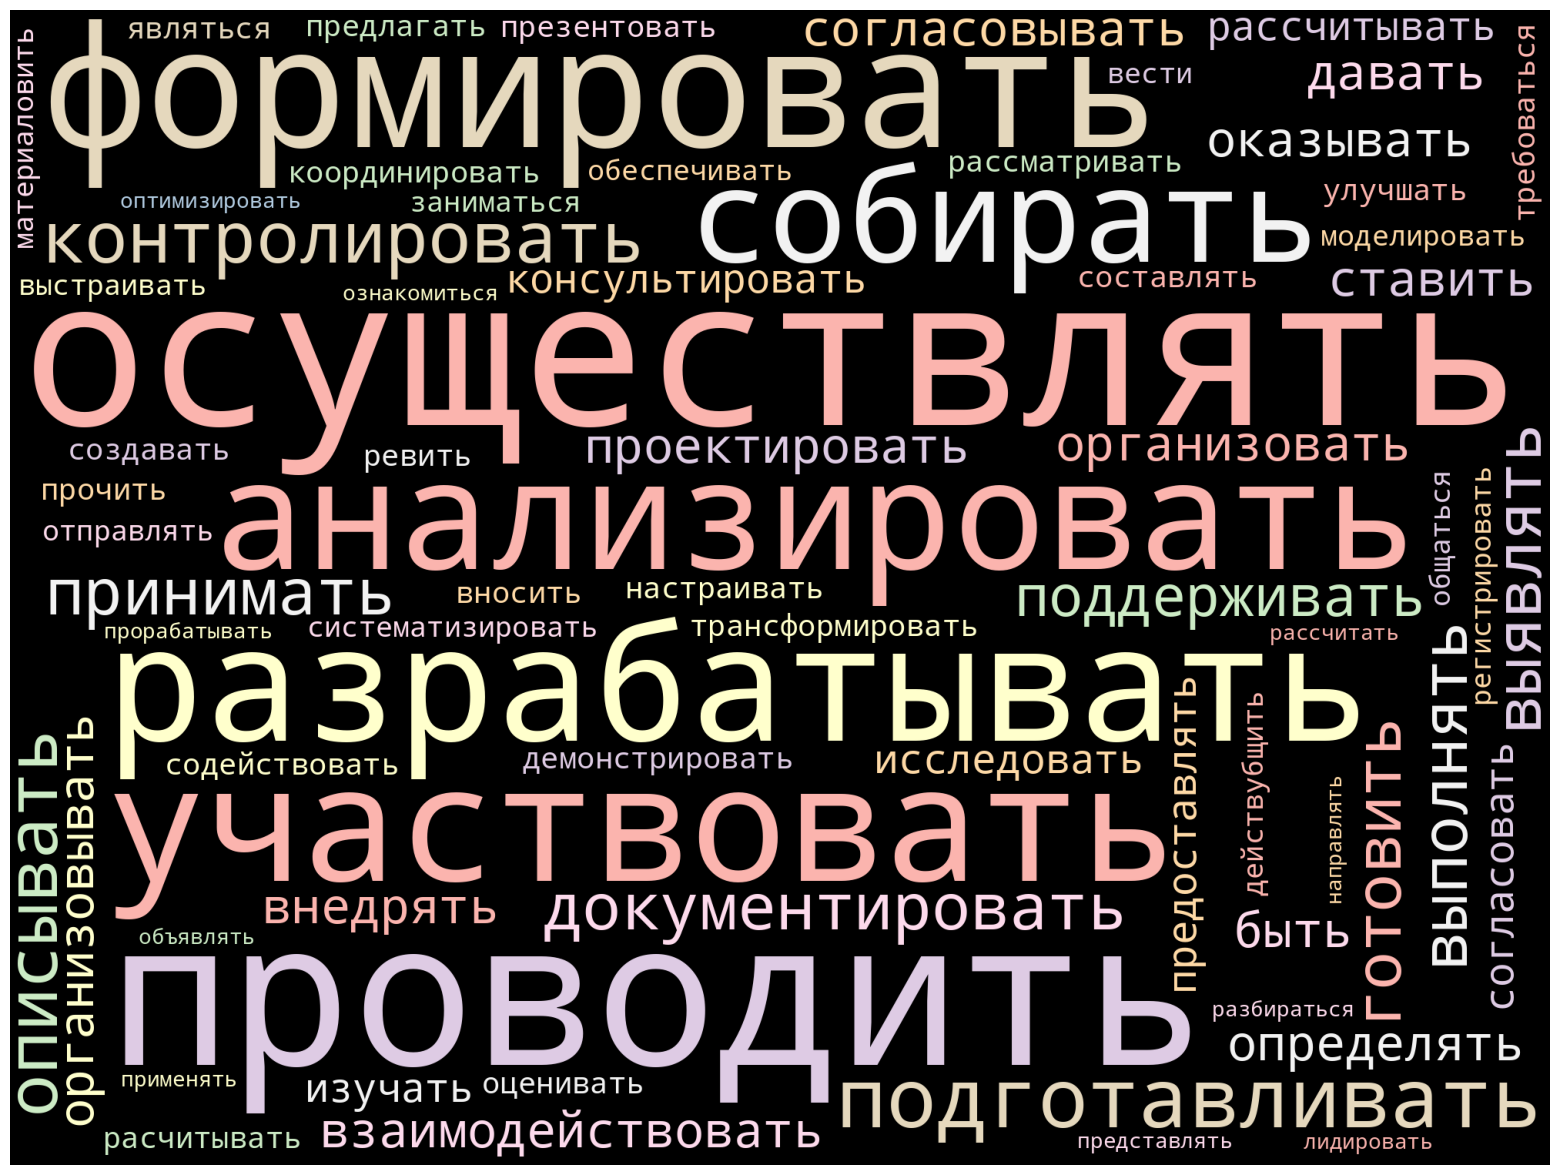

In [ ]:
wordcloud_verb = WordCloud(width = 2000,
                      height = 1500,
                      random_state=1,
                      background_color='black',
                      margin=20,
                      colormap='Pastel1',
                      collocations=False).generate(' '.join(verb_lst))

plot_cloud(wordcloud_verb) # Рисуем картинку